# Bank Payment Processor

This tool helps you process bank statements and match transactions to members in the database. The workflow consists of the following steps:

1. **Configure Import Settings**: Set up the file path and column mappings for your bank statement
2. **Load and Validate Data**: Import the bank statement and check for any issues
3. **Process Data**: Clean and normalize transaction data
4. **Match Members**: Match transactions to members in the database
5. **Export for Review**: Export the matched transactions to Excel for review

Each step is interactive with buttons to trigger the necessary actions. Simply run each cell in sequence and follow the instructions.

## Step 1: Configure Import Settings

Please set the following parameters for importing your bank statement:

- **File Path**: Full path to the Excel file containing the bank statement
- **Sheet**: Sheet name or index (0 = first sheet)
- **Column Names**: Specify which columns contain the transaction date, type, description, and amount
- **Minimum Amount**: Only transactions with an amount greater than this value will be processed

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import re
from datetime import datetime
from decimal import Decimal
import matplotlib.pyplot as plt
import warnings
import threading
from IPython.display import display, HTML
import ipywidgets as widgets
import fuzzywuzzy

# You may need these for Django integration
try:
    # Get the current notebook directory
    notebook_dir = os.path.abspath(os.path.dirname(os.path.realpath('__file__')))
    
    # Navigate up one level to the project root
    project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
    
    # Add project directory to Python path if not already there
    if project_dir not in sys.path:
        sys.path.insert(0, project_dir)
    
    # Set the Django settings module
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'yzer_membership.settings')
    
    # Initialize Django
    import django
    django.setup()
    
    # Import Django models and utilities
    from members.models import Member, PaymentRecord, BankStatementImport
    from django.db.models import Q
    from django.utils import timezone
    from django.db import transaction
    
    # Utility functions for thread-safe Django operations
    def run_in_thread(func, *args, **kwargs):
        """Run a function in a separate thread and return its result"""
        result_container = []
        error_container = []
        
        def thread_target():
            try:
                result = func(*args, **kwargs)
                result_container.append(result)
            except Exception as e:
                error_container.append(e)
        
        thread = threading.Thread(target=thread_target)
        thread.start()
        thread.join()
        
        if error_container:
            raise error_container[0]
        
        return result_container[0] if result_container else None
except Exception as e:
    print(f"Error setting up Django environment: {e}")


# Rest of your code remains the same...

# File path input
file_path_input = widgets.Text(
    value='C:\\Work\\active_projects\\Yzer_Conservancy\\data_input\\statement-08-240-533-6 Feb-July.xlsx',
    placeholder='Enter the full path to the Excel file',
    description='File Path:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='90%')
)

# Sheet selection (default to first sheet)
sheet_input = widgets.Text(
    value='0',
    placeholder='Sheet name or index (0 = first sheet)',
    description='Sheet:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Column name inputs
date_col_input = widgets.Text(
    value='Date',
    placeholder='Column name for transaction date',
    description='Date Column:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

type_col_input = widgets.Text(
    value='Type',
    placeholder='Column name for transaction type',
    description='Type Column:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

desc_col_input = widgets.Text(
    value='Description',
    placeholder='Column name for transaction description',
    description='Description Column:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

amount_col_input = widgets.Text(
    value='Amount',
    placeholder='Column name for transaction amount',
    description='Amount Column:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

# Minimum amount filter
min_amount_input = widgets.FloatText(
    value=50.0,
    description='Min Amount:',
    tooltip='Only consider transactions with amount greater than this value',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='40%')
)

# Create a settings dictionary
def get_settings():
    """Get current settings from widgets"""
    return {
        'file_path': file_path_input.value,
        'sheet': sheet_input.value,
        'date_col': date_col_input.value,
        'type_col': type_col_input.value,
        'description_col': desc_col_input.value,
        'amount_col': amount_col_input.value,
        'min_amount': min_amount_input.value
    }

# Display all inputs with nicer styling
settings_container = HTML("""
<div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin: 10px 0;">
    <h3 style="margin-top: 0; color: #495057;">Bank Statement Import Settings</h3>
    <p style="color: #6c757d;">Please enter the settings below for importing your bank statement:</p>
</div>
""")
display(settings_container)

file_section = widgets.VBox([
    widgets.HTML("<b>File Information:</b>"),
    file_path_input,
    sheet_input
])

column_section = widgets.VBox([
    widgets.HTML("<b>Column Mappings:</b>"),
    date_col_input,
    type_col_input, 
    desc_col_input,
    amount_col_input
])

filter_section = widgets.VBox([
    widgets.HTML("<b>Filter Settings:</b>"),
    min_amount_input
])

# Arrange widgets in a nicer layout
settings_layout = widgets.VBox([
    file_section, 
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    column_section,
    widgets.HTML("<hr style='margin: 10px 0;'>"),
    filter_section
])

display(settings_layout)


def clean_amount(amount_str):
    """
    Convert string amount to Decimal, handling different formats
    """
    if isinstance(amount_str, (int, float)):
        return Decimal(str(amount_str))
    
    if pd.isna(amount_str) or not amount_str:
        return Decimal('0.00')
    
    # Remove currency symbols, spaces, and commas
    cleaned = re.sub(r'[R\s,]', '', str(amount_str))
    
    try:
        return Decimal(cleaned)
    except:
        print(f"Warning: Could not convert '{amount_str}' to decimal. Using 0.00")
        return Decimal('0.00')
    




## Step 2: Load and Validate Data

Click the button below to load the bank statement based on your settings. The system will:
1. Check if the file exists
2. Validate that all required columns are present
3. Load the data and display a sample
4. Show basic statistics for the amount column

In [ ]:
def load_and_validate_statement(settings):
    """
    Load and validate bank statement data from Excel file
    """
    try:
        # Get settings
        file_path = settings['file_path']
        sheet = settings['sheet']
        date_col = settings['date_col']
        type_col = settings['type_col']
        description_col = settings['description_col']
        amount_col = settings['amount_col']
        min_amount = settings['min_amount']
        
        # Display the settings that will be used
        settings_html = f"""
        <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px; margin-bottom: 15px;">
            <h4 style="margin-top: 0;">Import Settings:</h4>
            <ul>
                <li><b>File:</b> {file_path}</li>
                <li><b>Sheet:</b> {sheet}</li>
                <li><b>Date Column:</b> {date_col}</li>
                <li><b>Type Column:</b> {type_col}</li>
                <li><b>Description Column:</b> {description_col}</li>
                <li><b>Amount Column:</b> {amount_col}</li>
                <li><b>Minimum Amount:</b> {min_amount}</li>
            </ul>
        </div>
        """
        display(HTML(settings_html))
        
        # Check if file exists
        if not os.path.exists(file_path):
            error_html = f"""
            <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
                <p style="color: #d32f2f; font-weight: bold;">❌ File not found: {file_path}</p>
                <p>Please check the file path and try again.</p>
            </div>
            """
            display(HTML(error_html))
            return None
        
        # Try to convert sheet to integer if it's a numeric string
        try:
            sheet = int(sheet)
        except ValueError:
            # Keep as string if it's not a number (sheet name)
            pass
        
        # Load Excel file
        df = pd.read_excel(file_path, sheet_name=sheet)
        
        success_html = f"""
        <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px;">
            <p style="color: #2e7d32; font-weight: bold;">✅ Successfully loaded {len(df)} transactions from {file_path}</p>
        </div>
        """
        display(HTML(success_html))
        
        # Check required columns
        required_cols = [date_col, type_col, description_col, amount_col]
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            error_html = f"""
            <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
                <p style="color: #d32f2f; font-weight: bold;">❌ Missing columns in Excel file: {', '.join(missing_cols)}</p>
                <p>Available columns: {', '.join(df.columns)}</p>
                <p>Please check your column mappings and try again.</p>
            </div>
            """
            display(HTML(error_html))
            return None
        
        # Filter to only include positive amounts
        payments_df = df[df[amount_col] >= min_amount].copy()
        
        filter_html = f"""
        <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px; margin-top: 10px;">
            <p style="color: #2e7d32; font-weight: bold;">✅ Found {len(payments_df)} potential payments (amount > {min_amount})</p>
            <p>Filtered out {len(df) - len(payments_df)} transactions with amount less than {min_amount}</p>
        </div>
        """
        display(HTML(filter_html))
        
        # Display sample data
        display(HTML("<h4 style='margin-top: 20px;'>🔍 Sample data (first 5 rows):</h4>"))
        display(payments_df.head().style.set_table_attributes('class="table table-striped table-hover"'))
        
        # Basic statistics
        display(HTML("<h4 style='margin-top: 20px;'>📊 Basic statistics for amount column:</h4>"))
        display(payments_df[amount_col].describe().to_frame().style.set_table_attributes('class="table table-bordered"'))
        
        return payments_df
        
    except Exception as e:
        error_html = f"""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Error loading Excel file:</p>
            <p>{str(e)}</p>
            <p>Please check your file and settings and try again.</p>
        </div>
        """
        display(HTML(error_html))
        return None

# Create a load button with styling
load_button = widgets.Button(
    description='Load Bank Statement',
    button_style='primary',
    icon='file-upload',
    tooltip='Load and validate the bank statement based on your settings',
    layout=widgets.Layout(width='auto')
)

# Function to handle button click
def on_load_button_clicked(b):
    global df, settings
    settings = get_settings()
    df = load_and_validate_statement(settings)
    
    # Display a warning if validation fails
    if df is None:
        warning_html = """
        <div style="background-color: #fff3e0; padding: 10px; border-radius: 5px; margin-top: 15px;">
            <p style="color: #e65100; font-weight: bold;">⚠️ Please fix the issues above and try again.</p>
        </div>
        """
        display(HTML(warning_html))

# Connect the button to the function
load_button.on_click(on_load_button_clicked)

# Display the button with a nice container
button_container = widgets.VBox([
    widgets.HTML('<div style="margin: 10px 0 5px 0;"><b>Click to load data:</b></div>'),
    load_button
])
display(button_container)

,id,Date,Amount,Type,Description,upload_timestamp,source_file,uploaded_by,upload_reference_code,Bank_Name,Bank_Account_No,uploaded_date
1,428,2025-07-30 00:00:00,91371.000000,ELECTRONIC BANKING PAYMENT FR,SWARTL MUN,2025-08-02 11:35:19.263000,statement-08-240-533-6 July 2025.xlsx,andye,UPL_20250802_113519_fe4d7230,Standard Bank,22-061-585-3,2025-08-02 00:00:00
2,429,2025-07-30 00:00:00,100.000000,IB PAYMENT FROM,WIEHANN VILJOEN MEMB/FEE,2025-08-02 11:35:19.263000,statement-08-240-533-6 July 2025.xlsx,andye,UPL_20250802_113519_fe4d7230,Standard Bank,22-061-585-3,2025-08-02 00:00:00
3,430,2025-07-30 00:00:00,100.000000,MAGTAPE CREDIT,JANE DOE OMFEE,2025-08-02 11:35:19.263000,statement-08-240-533-6 July 2025.xlsx,andye,UPL_20250802_113519_fe4d7230,Standard Bank,22-061-585-3,2025-08-02 00:00:00
4,431,2025-07-30 00:00:00,100.000000,CREDIT TRANSFER,ANNETTE VOTTELER,2025-08-02 11:35:19.263000,statement-08-240-533-6 July 2025.xlsx,andye,UPL_20250802_113519_fe4d7230,Standard Bank,22-061-585-3,2025-08-02 00:00:00
5,432,2025-07-30 00:00:00,100.000000,CREDIT TRANSFER,ABSA BANK Inus Viljoen O Mem F,2025-08-02 11:35:19.263000,statement-08-240-533-6 July 2025.xlsx,andye,UPL_20250802_113519_fe4d7230,Standard Bank,22-061-585-3,2025-08-02 00:00:00


,Amount
count,104.000000
mean,1428.567308
std,9213.229707
min,100.000000
25%,100.000000
50%,100.000000
75%,200.000000
max,91371.000000


## Step 3: Process Data

Click the button below to clean and normalize the transaction data. The system will:
1. Clean amount values (handling different formats)
2. Filter transactions by minimum amount
3. Standardize field names for consistent processing
4. Display a summary of the processed data and statistics

,Payment_Date,Reference,Description,Amount
1,2025-07-30 00:00:00,ELECTRONIC BANKING PAYMENT FR,SWARTL MUN,91371.0
2,2025-07-30 00:00:00,IB PAYMENT FROM,WIEHANN VILJOEN MEMB/FEE,100.0
3,2025-07-30 00:00:00,MAGTAPE CREDIT,JANE DOE OMFEE,100.0
4,2025-07-30 00:00:00,CREDIT TRANSFER,ANNETTE VOTTELER,100.0
5,2025-07-30 00:00:00,CREDIT TRANSFER,ABSA BANK Inus Viljoen O Mem F,100.0


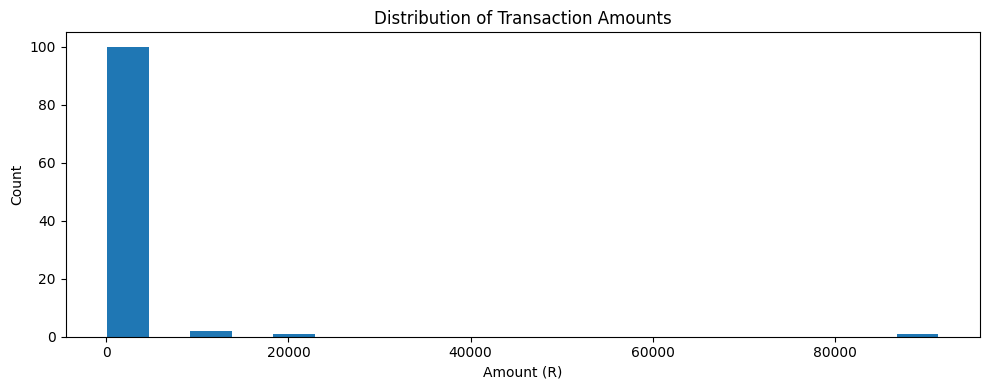

In [ ]:
def process_data(b):
    global df, settings
    
    if 'df' not in globals() or 'settings' not in globals() or df is None:
        error_html = """
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Please load data first (Step 2)</p>
            <p>You need to successfully load bank statement data before processing.</p>
        </div>
        """
        display(HTML(error_html))
        return
    
    # Extract settings
    date_col = settings['date_col']
    type_col = settings['type_col']
    description_col = settings['description_col']
    amount_col = settings['amount_col']
    min_amount = settings['min_amount']
    
    processing_html = """
    <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px;">
        <p style="font-weight: bold;">Processing transaction data...</p>
    </div>
    """
    display(HTML(processing_html))
    
    try:
        # Clean amount values
        df['Clean_Amount'] = df[amount_col].apply(clean_amount)
        
        # Filter transactions by amount (positive values above minimum)
        filtered_df = df[df['Clean_Amount'] >= min_amount].copy()
        
        # Count of filtered transactions
        filtered_count = len(filtered_df)
        excluded_count = len(df) - filtered_count
        
        # Add standardized fields
        filtered_df['Payment_Date'] = filtered_df[date_col]
        filtered_df['Reference'] = filtered_df[type_col].astype(str)
        filtered_df['Description'] = filtered_df[description_col].astype(str)
        filtered_df['Amount'] = filtered_df['Clean_Amount']
        
        # Update original dataframe
        df = filtered_df
        
        # Display results
        results_html = f"""
        <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px; margin-top: 15px;">
            <p style="color: #2e7d32; font-weight: bold;">✅ Processing complete:</p>
            <ul>
                <li>{filtered_count} transactions kept (amount >= {min_amount})</li>
                <li>{excluded_count} transactions excluded (amount < {min_amount})</li>
            </ul>
        </div>
        """
        display(HTML(results_html))
        
        # Display sample of processed data
        display(HTML("<h4 style='margin-top: 20px;'>Sample of processed data:</h4>"))
        display(df[['Payment_Date', 'Reference', 'Description', 'Amount']].head().style.set_table_attributes('class="table table-striped table-hover"'))
        
        # Display distribution of transaction amounts
        try:
            # Import matplotlib with proper backend configuration
            import matplotlib
            matplotlib.use('module://ipykernel.pylab.backend_inline')
            import matplotlib.pyplot as plt
            
            # Convert to numeric values and ensure they're floats
            numeric_amounts = pd.to_numeric(df['Amount'], errors='coerce')
            
            # Check if we have valid numeric data
            if numeric_amounts.notna().any():
                # Create the figure and plot
                plt.figure(figsize=(10, 4))
                numeric_amounts.plot(kind='hist', bins=20, title='Distribution of Transaction Amounts')
                plt.xlabel('Amount (R)')
                plt.ylabel('Count')
                plt.tight_layout()
                
                # Print some statistics about the amounts
                stats_html = f"""
                <div style="background-color: #f5f5f5; padding: 10px; border-radius: 5px; margin-top: 15px;">
                    <h4 style="margin-top: 0;">Amount Statistics:</h4>
                    <ul>
                        <li><b>Min:</b> R{numeric_amounts.min():.2f}</li>
                        <li><b>Max:</b> R{numeric_amounts.max():.2f}</li>
                        <li><b>Mean:</b> R{numeric_amounts.mean():.2f}</li>
                        <li><b>Median:</b> R{numeric_amounts.median():.2f}</li>
                    </ul>
                </div>
                """
                display(HTML(stats_html))
                
                # Display the plot
                plt.show()
            else:
                display(HTML("""
                <div style="background-color: #fff3e0; padding: 10px; border-radius: 5px; margin-top: 15px;">
                    <p style="color: #e65100; font-weight: bold;">Could not display histogram: No valid numeric data in the Amount column</p>
                    <p>Check that the Amount column contains proper numeric values</p>
                </div>
                """))
            
        except Exception as plot_err:
            display(HTML(f"""
            <div style="background-color: #fff3e0; padding: 10px; border-radius: 5px; margin-top: 15px;">
                <p style="color: #e65100; font-weight: bold;">Could not display histogram: {plot_err}</p>
                <p>Tip: Run 'pip install matplotlib' if matplotlib is not installed</p>
            </div>
            """))
        
    except Exception as e:
        error_html = f"""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Error processing data: {e}</p>
        </div>
        """
        display(HTML(error_html))
        import traceback
        traceback.print_exc()

# Create button for processing
process_button = widgets.Button(
    description='Process Data',
    button_style='primary',
    icon='filter',
    tooltip='Clean and normalize transaction data',
    layout=widgets.Layout(width='auto')
)

# Connect button to function
process_button.on_click(process_data)

# Display the button with a nice container
process_button_container = widgets.VBox([
    widgets.HTML('<div style="margin: 10px 0 5px 0;"><b>Click to process data:</b></div>'),
    process_button
])
display(process_button_container)

## Step 4: Match Members

Click the button below to match transactions to members in the database. The system will:
1. Extract potential names from transaction references and descriptions
2. Match these names against member records in the database
3. Use fuzzy matching for approximate matches
4. Display both matched and unmatched transactions

In [ ]:
def extract_potential_names(text):
    """
    Extract potential names from transaction text
    """
    if pd.isna(text) or not text:
        return []
    
    # Convert to string if it's not already
    text = str(text)
    
    # Find potential names (uppercase words or words with initial capital)
    potential_names = []
    
    # First, try to find common surname prefixes (van, de, etc.)
    words = re.findall(r'\b[A-Za-z]+\b', text)
    
    # Look for uppercase words or words with initial capital
    # These are more likely to be names
    for i, word in enumerate(words):
        # Skip very short words (likely not names)
        if len(word) < 3:
            continue
            
        # Check if word is all uppercase or has initial capital
        if word.isupper() or word[0].isupper():
            # Check for surname prefixes
            if i > 0 and words[i-1].lower() in ['van', 'de', 'du', 'der', 'den', 'la']:
                potential_names.append(f"{words[i-1]} {word}")
            else:
                potential_names.append(word)
    
    return potential_names


# First, let's make sure we have fuzzywuzzy for fuzzy matching
try:
    from fuzzywuzzy import fuzz
except ImportError:
    display(HTML("""
    <div style="background-color: #fffde7; padding: 10px; border-radius: 5px;">
        <p style="font-weight: bold;">⚠️ The fuzzywuzzy module is not installed. Installing now...</p>
    </div>
    """))
    import pip
    pip.main(['install', 'fuzzywuzzy'])
    from fuzzywuzzy import fuzz
    display(HTML("""
    <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px;">
        <p style="color: #2e7d32; font-weight: bold;">✅ fuzzywuzzy installed successfully</p>
    </div>
    """))

def match_members(b):
    global df, matched_records, unmatched_transactions, matched_df, unmatched_df, member_id_lookup
    
    if 'df' not in globals() or 'settings' not in globals() or df is None:
        error_html = """
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Please load and process data first (Steps 1-2)</p>
            <p>You need to successfully load and process bank statement data before matching.</p>
        </div>
        """
        display(HTML(error_html))
        return
    
    matching_html = """
    <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px;">
        <p style="font-weight: bold;">Matching transactions to members...</p>
        <p>This may take a moment depending on the number of transactions and members.</p>
    </div>
    """
    display(HTML(matching_html))
    
    try:
        # Get members from database using thread to avoid Django async issues
        def get_all_members():
            return list(Member.objects.all())
        
        all_members = run_in_thread(get_all_members)
        
        # Define the priority order for membership status
        status_priority = {
            'Paid Up Member': 1,
            'Unpaid Member': 2,
            'Subscribed': 3,
            'Contact': 4,
            'Cleaned': 5,
            'Pending': 6,
            'WhatsApp': 7
        }
        
        # Filter out members with blank names and sort by membership status priority
        filtered_members = []
        for member in all_members:
            first_name = getattr(member, 'first_name', '').strip()
            last_name = getattr(member, 'last_name', '').strip()
            
            # Skip members with blank full names
            if not first_name or not last_name:
                continue
                
            # Get membership status with appropriate display value
            membership_status = None
            try:
                status_code = member.membership_status
                status_choices = getattr(member, 'MEMBERSHIP_STATUS_CHOICES', None)
                if status_choices:
                    status_dict = dict(status_choices)
                    membership_status = status_dict.get(status_code, status_code)
                else:
                    membership_status = status_code
            except Exception:
                membership_status = "Unknown"
            
            # Add to filtered list with priority
            filtered_members.append({
                'member': member,
                'first_name': first_name,
                'last_name': last_name,
                'full_name': f"{first_name} {last_name}",
                'membership_status': membership_status,
                'priority': status_priority.get(membership_status, 999)  # Default to lowest priority if status not found
            })
        
        # Sort members by priority and then alphabetically by full_name
        filtered_members.sort(key=lambda x: (x['priority'], x['full_name'].lower()))
        
        # Extract the member objects back into the main list
        prioritized_members = [item['member'] for item in filtered_members]
        
        members_html = f"""
        <div style="background-color: #e8f5e9; padding: 10px; border-radius: 5px; margin-top: 10px;">
            <p style="color: #2e7d32;">Retrieved {len(all_members)} members from database</p>
            <p style="color: #2e7d32;">Using {len(prioritized_members)} members after filtering out blank names</p>
            <p style="color: #2e7d32;">Members prioritized by membership status and then sorted alphabetically</p>
        </div>
        """
        display(HTML(members_html))
        
        # Initialize match lists
        matched_records = []
        unmatched_transactions = []
        
        # Create member lookup for faster matching
        member_lookup = {}
        # Also create a member ID lookup for quick retrieval
        member_id_lookup = {}
        
        # Create lookups from the prioritized member list
        for member in prioritized_members:
            last_name = member.last_name.lower()
            first_name = member.first_name.lower()
            full_name = f"{first_name} {last_name}"
            
            if last_name not in member_lookup:
                member_lookup[last_name] = []
            member_lookup[last_name].append(member)
            
            if full_name not in member_lookup:
                member_lookup[full_name] = []
            member_lookup[full_name].append(member)
            
            # Add to ID lookup for quick member retrieval later
            member_id_lookup[member.id] = member
        
        # Settings
        date_col = settings['date_col']
        description_col = settings['description_col']
        type_col = settings['type_col']
        amount_col = settings['amount_col']
        
        # Process each transaction
        for idx, row in df.iterrows():
            reference = str(row[type_col]) if not pd.isna(row[type_col]) else ""
            description = str(row[description_col]) if not pd.isna(row[description_col]) else ""
            
            # Extract potential names from reference and description
            ref_names = extract_potential_names(reference)
            desc_names = extract_potential_names(description)
            
            # Combine and clean names
            all_names = ref_names + desc_names
            
            # Skip if no names found
            if not all_names:
                unmatched_transactions.append({
                    'row_index': idx,
                    'reference': reference,
                    'description': description,
                    'amount': row[amount_col],
                    'notes': "No names found in reference or description"
                })
                continue
            
            # Try to match each name
            matched = False
            matched_member = None
            match_type = ""
            score = 0
            notes = ""
            potential_matches = []
            
            for name in all_names:
                # Skip very short names (likely not names)
                if len(name) < 3:
                    continue
                
                # Try direct match on last name
                last_name = name.lower()
                if last_name in member_lookup:
                    # If multiple members have this last name, take highest match score
                    best_match = None
                    best_score = 0
                    
                    for member in member_lookup[last_name]:
                        # Calculate match score based on similarity to full name
                        member_full = f"{member.first_name.lower()} {member.last_name.lower()}"
                        current_score = fuzz.ratio(last_name, member.last_name.lower())
                        
                        # If reference contains more of the name, boost score
                        if member.first_name.lower() in reference.lower() or member.first_name.lower() in description.lower():
                            current_score += 20
                        
                        if current_score > best_score:
                            best_score = current_score
                            best_match = member
                    
                    if best_match and best_score > 80:
                        matched = True
                        matched_member = best_match
                        match_type = "Direct match on last name"
                        score = best_score
                        notes = f"Matched '{last_name}' with member {best_match.first_name} {best_match.last_name}"
                        break
                    elif best_match and best_score > 70:
                        potential_matches.append((best_match, best_score))
                
                # Try fuzzy matching if no direct match
                if not matched:
                    # Try fuzzy matching with prioritized members
                    for member in prioritized_members:
                        member_last = member.last_name.lower()
                        
                        # Calculate fuzzy match score
                        current_score = fuzz.ratio(last_name, member_last)
                        
                        # If score is high, consider it a match
                        if current_score > 80:
                            matched = True
                            matched_member = member
                            match_type = "Fuzzy match on last name"
                            score = current_score
                            notes = f"Fuzzy matched '{last_name}' with score {score}"
                            break
                        elif current_score > 70:  # Potential match
                            potential_matches.append((member, current_score))
            
            # If no high confidence match but we have potentials
            if not matched and potential_matches:
                # Sort by score descending
                potential_matches.sort(key=lambda x: x[1], reverse=True)
                potential_names = ", ".join([f"{m[0].first_name} {m[0].last_name} ({m[1]}%)" for m in potential_matches[:3]])
            
            # Record the match result
            if matched and matched_member:
                matched_records.append({
                    'row_index': idx,
                    'member': matched_member,
                    'match_type': match_type,
                    'score': score,
                    'notes': notes
                })
            else:
                potential_names = ", ".join([f"{m[0].first_name} {m[0].last_name} ({m[1]}%)" for m in potential_matches[:3]]) if potential_matches else ""
                unmatched_transactions.append({
                    'row_index': idx,
                    'reference': reference,
                    'description': description,
                    'amount': row[amount_col],
                    'potential_names': potential_names,
                    'notes': "No match found"
                })
        
        # Create DataFrames for display
        matched_data = []
        for record in matched_records:
            member = record['member']
            matched_data.append({
                'Transaction_Date': df.loc[record['row_index'], date_col],
                'Amount': df.loc[record['row_index'], amount_col],
                'Reference': df.loc[record['row_index'], type_col],
                'Description': df.loc[record['row_index'], description_col],
                'Matched_Member': f"{member.first_name} {member.last_name}",
                'Member_Email': member.email if hasattr(member, 'email') else '',
                'Match_Type': record['match_type'],
                'Score': record['score'],
                'Notes': record['notes']
            })
        
        unmatched_data = []
        for record in unmatched_transactions:
            idx = record['row_index']
            unmatched_data.append({
                'Transaction_Date': df.loc[idx, date_col],
                'Amount': df.loc[idx, amount_col],
                'Reference': df.loc[idx, type_col],
                'Description': df.loc[idx, description_col],
                'Potential_Matches': record.get('potential_names', ''),
                'Notes': record['notes']
            })
        
        # Create DataFrames
        matched_df = pd.DataFrame(matched_data)
        unmatched_df = pd.DataFrame(unmatched_data)
        
        # Display results summary
        results_html = f"""
        <div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 15px;">
            <h3 style="color: #2e7d32; margin-top: 0;">✅ Matching complete!</h3>
            <p style="font-size: 16px; margin-bottom: 5px;">✅ Found <b>{len(matched_df)}</b> matched transactions</p>
            <p style="font-size: 16px; margin-bottom: 5px;">❓ Found <b>{len(unmatched_df)}</b> unmatched transactions</p>
            
            <h4 style="margin-top: 15px;">Next Steps:</h4>
            <ol>
                <li>Review the matched and unmatched transactions below</li>
                <li>Click 'Export All Transactions' to create an Excel file for review</li>
            </ol>
        </div>
        """
        display(HTML(results_html))
        
        # Display DataFrames
        if len(matched_df) > 0:
            display(HTML("<h3 style='margin-top: 30px; padding: 5px 10px; background-color: #e8f5e9; border-radius: 3px;'>MATCHED TRANSACTIONS</h3>"))
            display(matched_df.style.set_table_attributes('class="table table-striped table-hover"'))
        
        if len(unmatched_df) > 0:
            display(HTML("<h3 style='margin-top: 30px; padding: 5px 10px; background-color: #fff3e0; border-radius: 3px;'>UNMATCHED TRANSACTIONS</h3>"))
            display(unmatched_df.style.set_table_attributes('class="table table-striped table-hover"'))
        
        # Return member_id_lookup for use in other functions
        return member_id_lookup
        
    except Exception as e:
        error_html = f"""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Error during matching: {str(e)}</p>
        </div>
        """
        display(HTML(error_html))
        import traceback
        traceback.print_exc()
        return None

# Create a button to trigger the matching process
match_button = widgets.Button(
    description='Match Members',
    button_style='primary',
    icon='people',
    tooltip='Match transactions to members',
    layout=widgets.Layout(width='auto')
)

# Connect the button to the match_members function
match_button.on_click(match_members)

# Display the button with a nice container
match_button_container = widgets.VBox([
    widgets.HTML('<div style="margin: 10px 0 5px 0;"><b>Click to start matching transactions to members:</b></div>'),
    match_button
])
display(match_button_container)

,Transaction_Date,Amount,Reference,Description,Matched_Member,Member_Email,Match_Type,Score,Notes
0,2025-07-30 00:00:00,91371.0,ELECTRONIC BANKING PAYMENT FR,SWARTL MUN,Pieter Swart,pieter@propertyeagles.co.za,Fuzzy match on last name,91,Fuzzy matched 'swartl' with score 91
1,2025-07-30 00:00:00,100.0,IB PAYMENT FROM,WIEHANN VILJOEN MEMB/FEE,Wiehann Andries Viljoen,wiehann1cecile@gmail.com,Direct match on last name,100,Matched 'viljoen' with member Wiehann Andries Viljoen
2,2025-07-30 00:00:00,100.0,MAGTAPE CREDIT,JANE DOE OMFEE,Eddie Janse,2mean4@gmail.com,Fuzzy match on last name,89,Fuzzy matched 'jane' with score 89
3,2025-07-30 00:00:00,100.0,CREDIT TRANSFER,ANNETTE VOTTELER,‪0824671295‬ Annette,None,Direct match on last name,100,Matched 'annette' with member ‪0824671295‬ Annette
4,2025-07-30 00:00:00,100.0,CREDIT TRANSFER,ABSA BANK Inus Viljoen O Mem F,Inus Viljoen,iviljoen@telkomsa.net,Direct match on last name,120,Matched 'viljoen' with member Inus Viljoen
5,2025-07-29 00:00:00,100.0,IB PAYMENT FROM,LEON AHLERS ORD MEMBERSHI,Leon Ahlers,leonahlers@me.com,Direct match on last name,120,Matched 'ahlers' with member Leon Ahlers
6,2025-07-25 00:00:00,100.0,MAGTAPE CREDIT,DAVID RUDD ORDINARY,David Rudd,zenzelelodge@gmail.com,Direct match on last name,120,Matched 'rudd' with member David Rudd
7,2025-07-14 00:00:00,100.0,IB PAYMENT FROM,PIETER LE ROUX ORD. M.SHI,Pieter Le Roux Pieter,None,Direct match on last name,120,Matched 'pieter' with member Pieter Le Roux Pieter
8,2025-07-14 00:00:00,100.0,IB PAYMENT FROM,DAVID WIGHTMAN 44 MAIN RD,David Wightman,info@vinylcafe.co.za,Direct match on last name,120,Matched 'wightman' with member David Wightman
9,2025-05-06 00:00:00,250.0,CREDIT TRANSFER,Donation Auram SA R Prag,Rashmi Prag,organics@auramsa.com,Direct match on last name,100,Matched 'prag' with member Rashmi Prag


,Transaction_Date,Amount,Reference,Description,Potential_Matches,Notes
0,2025-07-29 00:00:00,100.0,IB PAYMENT FROM,LEON KLOPPERORDENERY,,No match found
1,2025-07-14 00:00:00,100.0,CREDIT TRANSFER,ABSA BANK mike sanger,Ros Barbosa (73%),No match found
2,2025-07-07 00:00:00,10000.0,IB TRANSFER FROM,*****9977001 16H35 *****0473,,No match found
3,2025-05-31 00:00:00,300.0,CREDIT TRANSFER,DONATION,,No match found
4,2025-04-12 00:00:00,100.0,CREDIT TRANSFER,MALDAW,,No match found
5,2025-04-04 00:00:00,10000.0,IB TRANSFER FROM,*****9977001 15H35 *****0473,,No match found
6,2025-04-01 00:00:00,100.0,CREDIT TRANSFER,ABSA BANK mike sanger,Ros Barbosa (73%),No match found
7,2025-03-28 00:00:00,100.0,REAL TIME TRANSFER FROM,Alison ordinary1715831479,Kayla Matisson (71%),No match found
8,2025-03-04 00:00:00,20000.0,IB TRANSFER FROM,cashflow,,No match found
9,2025-03-04 00:00:00,100.0,CREDIT TRANSFER,ABSA BANK Hardie VS/0827377151,"Ros Barbosa (73%), Danie Sadie (73%), Aaniyah Omardien (71%)",No match found


## Step 5: Export for Review

Click the button below to export all transactions (both matched and unmatched) to a single Excel file for review. The export will:
1. Format the data for easy review (matched = green, unmatched = orange)
2. Include membership status and last payment information for each matched member
3. Add a special "Result" column that shows "Correct" for perfect matches
4. Include columns for manual verification and overrides
5. Add a member list sheet for reference
6. Include instructions for reviewing the data

In [5]:
def export_all_transactions_for_review(b):
    """
    Export all transactions (both matched and unmatched) to a single Excel file for review
    """
    global df, matched_records, unmatched_transactions, settings, member_id_lookup, matched_df, unmatched_df
    
    if 'df' not in globals() or df is None or len(df) == 0:
        display(HTML("""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ No transactions to export</p>
            <p>Please complete the previous steps first to load and match transactions.</p>
        </div>
        """))
        return None
    
    if 'matched_records' not in globals() or not matched_records:
        display(HTML("""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ No matched transactions to export</p>
            <p>Please complete the member matching step first.</p>
        </div>
        """))
        return None
    
    display(HTML("""
    <div style="background-color: #e3f2fd; padding: 10px; border-radius: 5px;">
        <p style="font-weight: bold;">Starting export process...</p>
        <p>Please wait while the Excel file is being created.</p>
    </div>
    """))
    
    try:
        import pandas as pd
        import os
        import datetime
        import xlsxwriter
        import subprocess
        import platform
        import sys
        
        # Get settings
        date_col = settings['date_col']
        type_col = settings['type_col']
        description_col = settings['description_col']
        amount_col = settings['amount_col']
        
        # Create a DataFrame for all transactions with match information
        all_transaction_data = []
        
        # Define the priority order for membership status
        status_priority = {
            'Paid Up Member': 1,
            'Unpaid Member': 2,
            'Subscribed': 3,
            'Contact': 4,
            'Cleaned': 5,
            'Pending': 6,
            'WhatsApp': 7
        }
        
        # Create a list of members for the Member List sheet - sorted by membership status priority and name
        member_list_data = []
        
        # First get all members from the database to create the member list
        def get_all_members():
            return list(Member.objects.all())
        
        all_members = run_in_thread(get_all_members)
        
        # Helper function to safely strip strings or return empty string for None
        def safe_strip(value):
            if value is None:
                return ""
            return str(value).strip()
        
        # Filter out members with blank names and add to list with priority information
        for member in all_members:
            try:
                # Use the safe_strip function to handle None values
                first_name = safe_strip(getattr(member, 'first_name', ''))
                last_name = safe_strip(getattr(member, 'last_name', ''))
                
                # Skip members with blank full names
                if not first_name and not last_name:
                    continue
                    
                # Get full name
                full_name = f"{first_name} {last_name}".strip()
                
                # Get email - use safe_strip to handle None
                email = safe_strip(getattr(member, 'email', ''))
                
                # Get membership status
                membership_status = None
                try:
                    status_code = member.membership_status
                    status_choices = getattr(member, 'MEMBERSHIP_STATUS_CHOICES', None)
                    if status_choices:
                        status_dict = dict(status_choices)
                        membership_status = status_dict.get(status_code, status_code)
                    else:
                        membership_status = status_code
                except Exception:
                    membership_status = "Unknown"
                
                # Get priority
                priority = status_priority.get(membership_status, 999)  # Default to lowest priority
                
                # Add to member list
                member_list_data.append({
                    'ID': member.id,
                    'Full_Name': full_name,
                    'First_Name': first_name,
                    'Last_Name': last_name,
                    'Email': email,
                    'Membership_Status': membership_status,
                    'Priority': priority
                })
            except Exception as e:
                # Skip members that cause errors
                continue
        
        # Sort member list by priority and then alphabetically by full name
        member_list_data.sort(key=lambda x: (x['Priority'], x['Full_Name'].lower()))
        
        # Create member list DataFrame
        member_list_df = pd.DataFrame(member_list_data)
        
        # Add matched records to all transactions
        for record in matched_records:
            row_idx = record['row_index']
            member = record['member']
            
            # Get transaction details
            transaction = {
                'Transaction_Date': df.loc[row_idx, date_col],
                'Amount': df.loc[row_idx, amount_col],
                'Reference': df.loc[row_idx, type_col],
                'Description': df.loc[row_idx, description_col],
                'Is_Matched': True,
                'Match_Score': record.get('score', 1.0),
                'Match_Type': record.get('match_type', 'Unknown'),
                'Matched_Member_ID': member.id,
                'Manually_Verified': False,  # Default - not manually verified yet
                'Notes': record.get('notes', '')
            }
            
            # Add member details - use safe_strip to handle None values
            first_name = safe_strip(getattr(member, 'first_name', ''))
            last_name = safe_strip(getattr(member, 'last_name', ''))
            
            transaction['Matched_Member_Name'] = f"{first_name} {last_name}".strip()
            transaction['Member_Email'] = safe_strip(getattr(member, 'email', ''))
            
            # Get membership status
            membership_status = None
            try:
                status_code = member.membership_status
                status_choices = getattr(member, 'MEMBERSHIP_STATUS_CHOICES', None)
                if status_choices:
                    status_dict = dict(status_choices)
                    membership_status = status_dict.get(status_code, status_code)
                else:
                    membership_status = status_code
            except Exception:
                membership_status = "Unknown"
            
            transaction['Membership_Status'] = membership_status
            
            # Set priority for sorting later
            transaction['Priority'] = status_priority.get(membership_status, 999)
            
            # Add to transaction list
            all_transaction_data.append(transaction)
        
        # Add unmatched records to all transactions
        for record in unmatched_transactions:
            row_idx = record['row_index']
            
            # Get transaction details
            transaction = {
                'Transaction_Date': df.loc[row_idx, date_col],
                'Amount': df.loc[row_idx, amount_col],
                'Reference': df.loc[row_idx, type_col],
                'Description': df.loc[row_idx, description_col],
                'Is_Matched': False,
                'Match_Score': 0,
                'Match_Type': 'Not Matched',
                'Matched_Member_ID': None,
                'Matched_Member_Name': None,
                'Member_Email': None,
                'Membership_Status': None,
                'Manually_Verified': False,
                'Priority': 1000,  # Set to lowest priority for sorting
                'Notes': record.get('notes', ''),
                'Potential_Matches': record.get('potential_names', '')
            }
            
            # Add to transaction list
            all_transaction_data.append(transaction)
        
        # Create DataFrame
        all_transactions_df = pd.DataFrame(all_transaction_data)
        
        # Sort by is matched first (matched first), then by priority, then by name alphabetically
        all_transactions_df = all_transactions_df.sort_values(
            by=['Is_Matched', 'Priority', 'Matched_Member_Name'], 
            ascending=[False, True, True]
        )
        
        # Generate timestamp for file name
        timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Set output path
        output_path = os.path.join(project_dir, 'data_output', f'bank_payments_for_review_{timestamp}.xlsx')
        
        # Create Excel file with formatting
        with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
            # Write transactions to sheet
            all_transactions_df.to_excel(writer, sheet_name='Transactions', index=False)
            
            # Write member list to separate sheet
            member_list_df.to_excel(writer, sheet_name='Member List', index=False)
            
            # Write instructions to separate sheet
            instructions_df = pd.DataFrame([
                ["Instructions for reviewing bank payment data:"],
                ["1. Review the transactions in the 'Transactions' sheet"],
                ["2. For matched transactions (green), check if the match is correct"],
                ["3. For unmatched transactions (amber), try to identify the member"],
                ["4. Use the 'Member List' sheet as a reference"],
                ["5. Once reviewed, import this file back into the system"],
                [""],
                ["Color Key:"],
                ["Green: Matched transactions - require confirmation"],
                ["Amber: Unmatched transactions - require manual matching"],
                [""]
            ])
            instructions_df.to_excel(writer, sheet_name='Instructions', index=False, header=False)
            
            # Get workbook and worksheet objects
            workbook = writer.book
            trans_worksheet = writer.sheets['Transactions']
            
            # Define formats
            header_format = workbook.add_format({
                'bold': True, 
                'bg_color': '#4472C4',  # Blue header
                'font_color': 'white',
                'border': 1,
                'align': 'center',
                'valign': 'vcenter'
            })
            
            # Matched format - Green
            matched_format = workbook.add_format({
                'bg_color': '#C6E0B4',  # Soft green
                'border': 1
            })
            
            # Unmatched format - Amber/Orange
            unmatched_format = workbook.add_format({
                'bg_color': '#FFE699',  # Amber
                'border': 1
            })
            
            # Special formats for specific columns
            amount_format = workbook.add_format({
                'num_format': 'R #,##0.00',
                'border': 1
            })
            
            matched_amount_format = workbook.add_format({
                'num_format': 'R #,##0.00',
                'bg_color': '#C6E0B4',  # Soft green
                'border': 1
            })
            
            unmatched_amount_format = workbook.add_format({
                'num_format': 'R #,##0.00',
                'bg_color': '#FFE699',  # Amber
                'border': 1
            })
            
            date_format = workbook.add_format({
                'num_format': 'yyyy-mm-dd',
                'border': 1
            })
            
            matched_date_format = workbook.add_format({
                'num_format': 'yyyy-mm-dd',
                'bg_color': '#C6E0B4',  # Soft green
                'border': 1
            })
            
            unmatched_date_format = workbook.add_format({
                'num_format': 'yyyy-mm-dd',
                'bg_color': '#FFE699',  # Amber
                'border': 1
            })
            
            # Format the Transactions sheet
            for col_num, col_name in enumerate(all_transactions_df.columns):
                trans_worksheet.write(0, col_num, col_name, header_format)
                
                # Set column width based on content type
                if col_name in ['Transaction_Date']:
                    width = 15  # Fixed width for date columns
                elif col_name in ['Amount']:
                    width = 15  # Fixed width for amount columns
                elif col_name in ['Description']:
                    width = 40  # Larger width for description
                elif col_name in ['Matched_Member_Name', 'Member_Email']:
                    width = 30  # Fixed width for name/email columns
                else:
                    # Auto-fit column width based on content for other columns
                    max_len = max(
                        all_transactions_df[col_name].astype(str).map(len).max(),
                        len(col_name)
                    )
                    width = min(max_len + 2, 30)  # Cap width at 30 characters
                
                trans_worksheet.set_column(col_num, col_num, width)
            
            # Apply conditional formatting to rows
            matched_rows = []
            unmatched_rows = []
            
            for row_num, row_data in enumerate(all_transactions_df.itertuples(), start=1):
                if row_data.Is_Matched:
                    matched_rows.append(row_num)
                    # Format amount column with matched format
                    amount_col_idx = all_transactions_df.columns.get_loc('Amount')
                    trans_worksheet.write(row_num, amount_col_idx, row_data.Amount, matched_amount_format)
                    
                    # Format date column with matched format
                    date_col_idx = all_transactions_df.columns.get_loc('Transaction_Date')
                    trans_worksheet.write(row_num, date_col_idx, row_data.Transaction_Date, matched_date_format)
                else:
                    unmatched_rows.append(row_num)
                    # Format amount column with unmatched format
                    amount_col_idx = all_transactions_df.columns.get_loc('Amount')
                    trans_worksheet.write(row_num, amount_col_idx, row_data.Amount, unmatched_amount_format)
                    
                    # Format date column with unmatched format
                    date_col_idx = all_transactions_df.columns.get_loc('Transaction_Date')
                    trans_worksheet.write(row_num, date_col_idx, row_data.Transaction_Date, unmatched_date_format)
            
            # Apply formats to all rows
            for row in matched_rows:
                trans_worksheet.set_row(row, None, matched_format)
                
            for row in unmatched_rows:
                trans_worksheet.set_row(row, None, unmatched_format)
            
            # Freeze the header row and first two columns
            trans_worksheet.freeze_panes(1, 2)
            
            # Add filter to header
            trans_worksheet.autofilter(0, 0, len(all_transactions_df), len(all_transactions_df.columns) - 1)
            
            # Format the Member List sheet
            member_worksheet = writer.sheets['Member List']
            
            # Define member list header format
            member_header_format = workbook.add_format({
                'bold': True, 
                'bg_color': '#4472C4',  # Blue header
                'font_color': 'white',
                'border': 1,
                'align': 'center',
                'valign': 'vcenter'
            })
            
            # Define formats for different membership statuses
            paid_member_format = workbook.add_format({
                'bg_color': '#C6E0B4',  # Soft green - Paid members
                'border': 1
            })
            
            unpaid_member_format = workbook.add_format({
                'bg_color': '#FFE699',  # Amber - Unpaid members
                'border': 1
            })
            
            contact_format = workbook.add_format({
                'bg_color': '#F8CBAD',  # Light orange - Contacts
                'border': 1
            })
            
            other_format = workbook.add_format({
                'bg_color': '#E7E6E6',  # Light gray - Other statuses
                'border': 1
            })
            
            for col_num, col_name in enumerate(member_list_df.columns):
                member_worksheet.write(0, col_num, col_name, member_header_format)
                
                # Set column width based on content type
                if col_name in ['ID']:
                    width = 8  # Fixed width for ID column
                elif col_name in ['Full_Name', 'First_Name', 'Last_Name']:
                    width = 25  # Fixed width for name columns
                elif col_name in ['Email']:
                    width = 35  # Larger width for email
                else:
                    # Auto-fit column width based on content for other columns
                    max_len = max(
                        member_list_df[col_name].astype(str).map(len).max(),
                        len(col_name)
                    )
                    width = min(max_len + 2, 30)  # Cap width at 30 characters
                
                member_worksheet.set_column(col_num, col_num, width)
            
            # Apply conditional formatting to rows in member list based on membership status
            for row_num, row_data in enumerate(member_list_df.itertuples(), start=1):
                status = row_data.Membership_Status if hasattr(row_data, 'Membership_Status') else None
                
                if status == 'Paid Up Member':
                    member_worksheet.set_row(row_num, None, paid_member_format)
                elif status == 'Unpaid Member':
                    member_worksheet.set_row(row_num, None, unpaid_member_format)
                elif status in ['Contact', 'Subscribed']:
                    member_worksheet.set_row(row_num, None, contact_format)
                else:
                    member_worksheet.set_row(row_num, None, other_format)
            
            # Freeze the header row and first column in the member list
            member_worksheet.freeze_panes(1, 1)
            
            # Add filter to member list header
            member_worksheet.autofilter(0, 0, len(member_list_df), len(member_list_df.columns) - 1)
            
            # Format the Instructions sheet
            inst_worksheet = writer.sheets['Instructions']
            inst_worksheet.set_column(0, 0, 80)  # Set column width
            
            # Add title format
            title_format = workbook.add_format({
                'bold': True,
                'font_size': 14,
                'font_color': '#4472C4'
            })
            
            # Add section heading format
            section_format = workbook.add_format({
                'bold': True,
                'font_size': 12,
                'font_color': '#44546A'
            })
            
            # Add color key format
            color_key_matched = workbook.add_format({
                'bg_color': '#C6E0B4',  # Soft green
                'border': 1
            })
            
            color_key_unmatched = workbook.add_format({
                'bg_color': '#FFE699',  # Amber
                'border': 1
            })
            
            inst_worksheet.write(0, 0, "Instructions for Bank Payment Review", title_format)
            inst_worksheet.write(7, 0, "Color Key:", section_format)
            inst_worksheet.write_blank(8, 0, None, color_key_matched)
            inst_worksheet.write(8, 1, "Matched transactions")
            inst_worksheet.write_blank(9, 0, None, color_key_unmatched)
            inst_worksheet.write(9, 1, "Unmatched transactions")
        
        # Function to open file with default application
        def open_file(filepath):
            if platform.system() == 'Windows':
                os.startfile(filepath)
            elif platform.system() == 'Darwin':  # macOS
                subprocess.call(('open', filepath))
            else:  # Linux and other OS
                subprocess.call(('xdg-open', filepath))
        
        # Open the Excel file automatically
        try:
            open_file(output_path)
            auto_open_status = "✅ File opened automatically"
        except Exception as open_err:
            auto_open_status = f"⚠️ Could not open file automatically: {str(open_err)}"
        
        # Display success message with link to download
        success_html = f"""
        <div style="background-color: #e8f5e9; padding: 15px; border-radius: 5px; margin-top: 15px;">
            <h3 style="color: #2e7d32; margin-top: 0;">✅ Export complete!</h3>
            <p style="font-size: 16px; margin-bottom: 5px;">Exported <b>{len(all_transactions_df)}</b> transactions to Excel file.</p>
            <p style="font-size: 16px; margin-bottom: 5px;">File saved to: <b>{output_path}</b></p>
            <p style="font-size: 16px; margin-bottom: 5px;">{auto_open_status}</p>
            <p style="font-size: 16px; margin-bottom: 5px;">Transactions sorted by membership status priority, then alphabetically by name.</p>
            <p style="font-size: 16px; margin-bottom: 5px;">Member list included with <b>{len(member_list_df)}</b> members, sorted by membership status priority, then alphabetically by name.</p>
        </div>
        """
        display(HTML(success_html))
        
        return output_path
        
    except Exception as e:
        error_html = f"""
        <div style="background-color: #ffebee; padding: 10px; border-radius: 5px;">
            <p style="color: #d32f2f; font-weight: bold;">❌ Error during export: {str(e)}</p>
        </div>
        """
        display(HTML(error_html))
        import traceback
        traceback.print_exc()
        return None

# Create export button
export_button = widgets.Button(
    description='Export All Transactions',
    button_style='info',
    icon='file-excel',
    tooltip='Export all transactions to Excel for review',
    layout=widgets.Layout(width='auto')
)

# Connect button to function
export_button.on_click(export_all_transactions_for_review)

# Display the button with a nice container
export_button_container = widgets.VBox([
    widgets.HTML('<div style="margin: 10px 0 5px 0;"><b>Click to export all transactions:</b></div>'),
    export_button
])
display(export_button_container)

## Summary and Help

This tool helps you process bank statements and match transactions to members in your database. To use it:

1. **Configure import settings**: Set the file path and column mappings for your bank statement
2. **Load and validate data**: Import the bank statement data
3. **Process data**: Clean and normalize the transaction data
4. **Match members**: Match transactions to members in the database
5. **Export for review**: Create an Excel file for reviewing and manually verifying matches

If you need to see the code behind any step, click the "Show Code" button at the top of the notebook. The code will be visible until you click "Hide Code" again.

For more help or to report issues, please contact the system administrator.